# Importing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import datetime



In [2]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data_parse_dt(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url, parse_dates=[['DATE','TIME']], keep_date_col=True))
    return pd.concat(dfs)
        
week_nums = [190601, 190608, 190615]
turnstiles_df = get_data_parse_dt(week_nums)

In [3]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

In [4]:
turnstiles_df.DATE.value_counts().sort_index()

05/25/2019    28855
05/26/2019    29063
05/27/2019    29068
05/28/2019    28873
05/29/2019    29095
05/30/2019    29190
05/31/2019    29651
06/01/2019    29066
06/02/2019    28968
06/03/2019    30022
06/04/2019    29513
06/05/2019    29484
06/06/2019    29213
06/07/2019    28745
06/08/2019    29030
06/09/2019    29133
06/10/2019    29351
06/11/2019    29113
06/12/2019    30023
06/13/2019    29276
06/14/2019    29008
Name: DATE, dtype: int64

In [5]:
from datetime import datetime as dt

In [6]:
# mask = ((turnstiles_df["C/A"] == "A002") &
#         (turnstiles_df["UNIT"] == "R051") & 
#         (turnstiles_df["SCP"] == "02-00-00") & 
#         (turnstiles_df["STATION"] == "59 ST"))
# turnstiles_df[mask].head()

In [7]:
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
145002,N045,R187,01-06-00,81 ST-MUSEUM,2019-06-02 17:00:00,2
144620,N045,R187,01-00-00,81 ST-MUSEUM,2019-06-01 17:00:00,2
144871,N045,R187,01-00-02,81 ST-MUSEUM,2019-06-01 17:00:00,2
434865,R174,R034,00-00-02,125 ST,2019-06-08 00:00:00,2
144746,N045,R187,01-00-01,81 ST-MUSEUM,2019-06-01 17:00:00,2


In [8]:
turnstiles_df.DESC.value_counts()

REGULAR       611516
RECOVR AUD      2224
Name: DESC, dtype: int64

In [9]:
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [10]:
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2019-05-25 00:00:00,1
409147,R139,R031,04-00-01,34 ST-PENN STA,2019-06-02 08:00:00,1
409149,R139,R031,04-00-01,34 ST-PENN STA,2019-06-02 16:00:00,1
409150,R139,R031,04-00-01,34 ST-PENN STA,2019-06-02 20:00:00,1
409151,R139,R031,04-00-01,34 ST-PENN STA,2019-06-03 00:00:00,1


In [11]:
# Drop Exits and Desc Column.  To prevent errors in multiple run of cell, errors on drop is ignored
entries_df = turnstiles_df.drop(["EXITS", "DESC"], axis=1, errors="ignore")

In [12]:
entries_daily = (entries_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())

In [13]:
entries_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,05/25/2019,7072456
1,A002,R051,02-00-00,59 ST,05/26/2019,7073114
2,A002,R051,02-00-00,59 ST,05/27/2019,7073837
3,A002,R051,02-00-00,59 ST,05/28/2019,7075260
4,A002,R051,02-00-00,59 ST,05/29/2019,7076789


In [14]:
entries_daily[["PREV_DATE", "PREV_ENTRIES"]] = (entries_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

/home/luke/miniconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [15]:
# Drop the rows for the earliest date in the df
entries_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [16]:
entries_daily[entries_daily["ENTRIES"] < entries_daily["PREV_ENTRIES"]].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1618,A025,R023,01-03-01,34 ST-HERALD SQ,05/26/2019,1238366337,05/25/2019,1.238369e+09
1619,A025,R023,01-03-01,34 ST-HERALD SQ,05/27/2019,1238364310,05/26/2019,1.238366e+09
1620,A025,R023,01-03-01,34 ST-HERALD SQ,05/28/2019,1238360334,05/27/2019,1.238364e+09
1621,A025,R023,01-03-01,34 ST-HERALD SQ,05/29/2019,1238356306,05/28/2019,1.238360e+09
1622,A025,R023,01-03-01,34 ST-HERALD SQ,05/30/2019,1238352363,05/29/2019,1.238356e+09


In [17]:
# What's the deal with counter being in reverse
mask = ((entries_df["C/A"] == "A025") & 
(entries_df["UNIT"] == "R023") & 
(entries_df["SCP"] == "01-03-01") & 
(entries_df["STATION"] == "34 ST-HERALD SQ") &
(entries_df["DATE_TIME"].dt.date == datetime.datetime(2019, 5, 26).date()))
entries_df[mask].head()

,DATE_TIME,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES
3269,2019-05-26 20:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,20:00:00,1238366337
3268,2019-05-26 16:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,16:00:00,1238366929
3267,2019-05-26 12:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,12:00:00,1238367347
3266,2019-05-26 08:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,08:00:00,1238367539
3265,2019-05-26 04:00:00,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,05/26/2019,04:00:00,1238367622


In [18]:
# Let's see how many stations have this problem

(entries_daily[entries_daily["ENTRIES"] < entries_daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION        
A025  R023  01-03-01  34 ST-HERALD SQ    20
A043  R462  00-06-00  CANAL ST            1
A049  R088  02-05-00  CORTLANDT ST       18
A066  R118  00-00-00  CANAL ST           20
B020  R263  00-03-00  AVENUE H            1
                                         ..
R523  R147  00-00-04  61 ST WOODSIDE     20
R621  R060  00-03-01  EASTN PKWY-MUSM     2
R622  R123  00-00-00  FRANKLIN AV        20
R646  R110  01-00-01  FLATBUSH AV-B.C    20
R730  R431  00-00-04  EASTCHSTER/DYRE    20
Length: 401, dtype: int64

In [19]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
entries_daily["DAILY_ENTRIES"] = entries_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

1376283 8703.0
371 4317056.0
1790 13967417.0
221 7246254.0
4050694 5902992.0
7246468 4050451.0
5571815 104607574.0
459063 4526857.0
228 1393341.0
1828703861 9687851.0
126 4086499.0
1834 2588198.0
149 1252883.0
580 1650137.0
820 1523029.0
366 1047791.0
840 1251816.0
634 1572569.0
857 3126422.0
1113 1946726.0
1057 1214910.0
291 1309224.0
1484 1063313.0
1317 2409654.0
1060 1093122.0
1061 1461284.0
1472 1054311.0
1088 2725203.0
2095 2041280.0
1 1910177.0
212 1003601.0
531 3209791.0
2452 1395536.0
2094 2286050.0
1958 1696178.0
1977 1058528.0
0 1078800.0
2257 2792918.0
14 1327005.0
393281 1661809141.0
323 7193764.0
330 203977549.0
452993419 1830432.0
774 3000575.0
183 1488278.0


In [85]:
entries_daily["DAILY_ENTRIES"] = entries_daily.apply(get_daily_counts, axis=1, max_counter=500000)

1376283 8703.0
371 4317056.0
1790 13967417.0
221 7246254.0
4050694 5902992.0
7246468 4050451.0
5571815 104607574.0
459063 4526857.0
0 966871.0
852339 658.0
228 1393341.0
1828703861 9687851.0
126 4086499.0
1834 2588198.0
149 1252883.0
216 728932.0
553 883514.0
580 1650137.0
471 796882.0
820 1523029.0
375 936362.0
366 1047791.0
761 564967.0
932 607519.0
840 1251816.0
634 1572569.0
572 527380.0
857 3126422.0
1113 1946726.0
1057 1214910.0
1154 968173.0
594 533833.0
291 1309224.0
215 778553.0
89 556763.0
1484 1063313.0
1924 852022.0
1317 2409654.0
1060 1093122.0
950 869016.0
1 618239.0
478 975675.0
1061 1461284.0
1472 1054311.0
1088 2725203.0
2095 2041280.0
1 1910177.0
212 1003601.0
531 3209791.0
2452 1395536.0
2094 2286050.0
238 733761.0
1958 1696178.0
1977 1058528.0
2019 987950.0
0 1078800.0
2291 907453.0
2257 2792918.0
97 540908.0
103 535011.0
1692 558863.0
1787 608348.0
14 1327005.0
393281 1661809141.0
323 7193764.0
330 203977549.0
452993419 1830432.0
774 3000575.0
183 1488278.0


In [102]:
entries_daily.max()

C/A                    TRAM2
UNIT                    R572
SCP                 05-06-01
STATION            ZEREGA AV
DATE              06/14/2019
ENTRIES           2129287230
PREV_DATE         06/13/2019
PREV_ENTRIES     2.12929e+09
DAILY_ENTRIES         496176
dtype: object

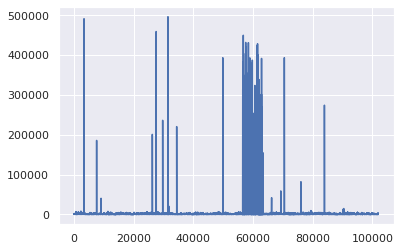

In [87]:
entries_daily['DAILY_ENTRIES'].plot()

In [88]:
entries_daily.groupby(['DATE', 'STATION']).sum().sort_values('DAILY_ENTRIES', ascending=False).head(20)

,,ENTRIES,PREV_ENTRIES,DAILY_ENTRIES
DATE,STATION,,,
06/07/2019,JOURNAL SQUARE,9046,6.107889e+06,3567458.0
06/04/2019,PATH NEW WTC,136428,3.841291e+06,2584714.0
06/11/2019,LACKAWANNA,3684,3.400425e+06,2393564.0
06/10/2019,EXCHANGE PLACE,11564,1.108864e+07,2390720.0
06/05/2019,NEWARK BM BW,876669,3.751815e+06,2343498.0
06/11/2019,CITY / BUS,9279,3.361374e+06,2292696.0
06/06/2019,NEWARK C,109415,2.769246e+06,2125672.0
06/05/2019,NEWARK HW BMEBE,1881,2.933092e+06,1678638.0
06/06/2019,HARRISON,18777,2.329452e+06,1582537.0


In [89]:
entries_daily.groupby(['STATION']).sum().sort_values('DAILY_ENTRIES', ascending=False).head(20)

,ENTRIES,PREV_ENTRIES,DAILY_ENTRIES
STATION,,,
PATH NEW WTC,43474694,4.827053e+07,5337577.0
JOURNAL SQUARE,72604647,7.830807e+07,4035520.0
NEWARK BM BW,38348216,4.186904e+07,3444655.0
34 ST-PENN STA,76803550879,7.680085e+10,3153573.0
EXCHANGE PLACE,165528280,1.763902e+08,2717777.0
CITY / BUS,52958543,5.613584e+07,2674655.0
GRD CNTRL-42 ST,52053190060,5.205066e+10,2581983.0
LACKAWANNA,53363808,5.659939e+07,2554737.0
GROVE STREET,77386722,8.248863e+07,2543893.0


In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

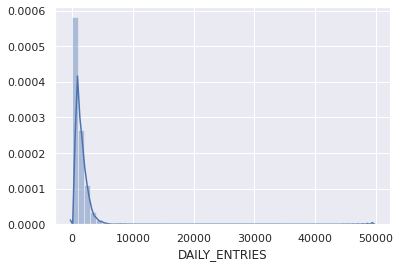

In [90]:
sns.distplot(entries_daily['DAILY_ENTRIES']
             [entries_daily['DAILY_ENTRIES'] < 50000])

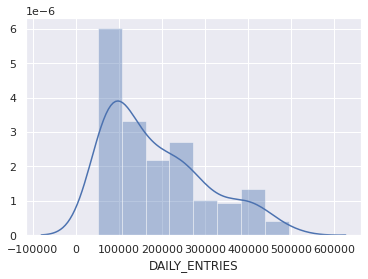

In [91]:
sns.distplot(entries_daily['DAILY_ENTRIES']
             [entries_daily['DAILY_ENTRIES'] > 50000])

In [92]:
# first get daily entries by station
stations_daily = \
(entries_daily.groupby(['STATION','DATE'])['DAILY_ENTRIES'].sum()
                 .reset_index())

stations_daily.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,05/26/2019,5172.0
1,1 AV,05/27/2019,4808.0
2,1 AV,05/28/2019,16825.0
3,1 AV,05/29/2019,18800.0
4,1 AV,05/30/2019,18948.0


In [93]:
# then get top 10 stations by daily volume 
# (sum across all days is a reasonable way to define this)
top10_stations = \
    (stations_daily.groupby(['STATION'])['DAILY_ENTRIES'].sum()
                   .reset_index()
                   .sort_values(by='DAILY_ENTRIES',ascending=False) 
                   .STATION.head(10))

top10_stations

314       PATH NEW WTC
257     JOURNAL SQUARE
297       NEWARK BM BW
61      34 ST-PENN STA
212     EXCHANGE PLACE
183         CITY / BUS
232    GRD CNTRL-42 ST
267         LACKAWANNA
234       GROVE STREET
46               23 ST
Name: STATION, dtype: object

In [103]:
type(top10_stations)

pandas.core.series.Series

In [94]:
# next create a new df that filters the stations daily data down
# to the top 10 stations
stations_daily_top10 = \
    stations_daily[stations_daily['STATION'].isin(top10_stations)]

In [95]:
stations_daily_top10.head()

,STATION,DATE,DAILY_ENTRIES
919,23 ST,05/26/2019,42949.0
920,23 ST,05/27/2019,40984.0
921,23 ST,05/28/2019,108274.0
922,23 ST,05/29/2019,124173.0
923,23 ST,05/30/2019,124277.0


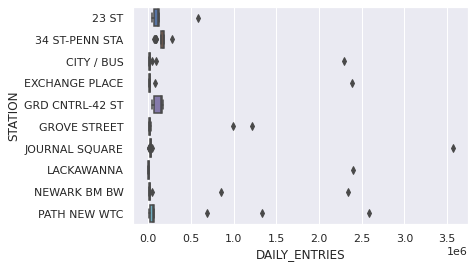

In [96]:
# use seaborn to create a boxplot by station
sns.boxplot('DAILY_ENTRIES', 'STATION', data=stations_daily_top10)

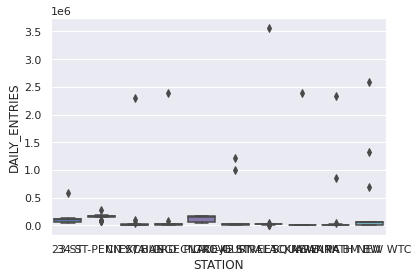

In [99]:
# use seaborn to create a boxplot by station
sns.boxplot('STATION', 'DAILY_ENTRIES', data=stations_daily_top10)

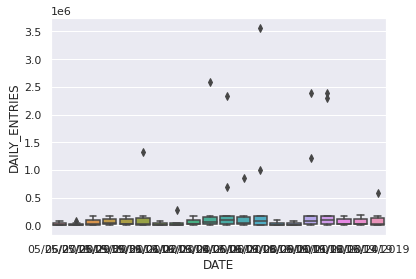

In [101]:
# use seaborn to create a boxplot by station
sns.boxplot('DATE', 'DAILY_ENTRIES', data=stations_daily_top10)

In [76]:
# then get top 10 stations by daily volume 
# (sum across all days is a reasonable way to define this)
top20_stations = \
    (entries_daily.groupby(['STATION'])['DAILY_ENTRIES'].sum()
                   .reset_index()
                   .sort_values(by='DAILY_ENTRIES',ascending=False) 
                   .STATION.head(20))

top20_stations

314       PATH NEW WTC
257     JOURNAL SQUARE
212     EXCHANGE PLACE
234       GROVE STREET
297       NEWARK BM BW
316    PAVONIA/NEWPORT
351    THIRTY THIRD ST
61      34 ST-PENN STA
298           NEWARK C
183         CITY / BUS
232    GRD CNTRL-42 ST
267         LACKAWANNA
188    CLINTON-WASH AV
238           HARRISON
46               23 ST
17         14TH STREET
59     34 ST-HERALD SQ
172           CANAL ST
225          FULTON ST
352     TIMES SQ-42 ST
Name: STATION, dtype: object

In [77]:
# next create a new df that filters the stations daily data down
# to the top 20 stations
stations_daily_top20 = \
    stations_daily[stations_daily['STATION'].isin(top20_stations)]

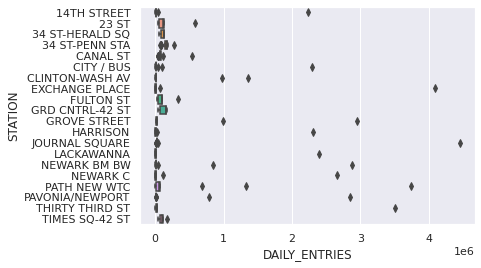

In [78]:
# use seaborn to create a boxplot by station
sns.boxplot('DAILY_ENTRIES', 'STATION', data=stations_daily_top20)

In [79]:
clean_entries_daily = entries_daily.drop(['ENTRIES', 'PREV_DATE', 'PREV_ENTRIES'], axis=1)

In [80]:
clean_entries_daily.head()

,C/A,UNIT,SCP,STATION,DATE,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,05/26/2019,658.0
2,A002,R051,02-00-00,59 ST,05/27/2019,723.0
3,A002,R051,02-00-00,59 ST,05/28/2019,1423.0
4,A002,R051,02-00-00,59 ST,05/29/2019,1529.0
5,A002,R051,02-00-00,59 ST,05/30/2019,1484.0


In [81]:
date_entries_daily = clean_entries_daily

In [82]:
date_entries_daily['DATE'] = pd.to_datetime(date_entries_daily['DATE'])
date_entries_daily.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 97067 entries, 1 to 101948
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   C/A            97067 non-null  object        
 1   UNIT           97067 non-null  object        
 2   SCP            97067 non-null  object        
 3   STATION        97067 non-null  object        
 4   DATE           97067 non-null  datetime64[ns]
 5   DAILY_ENTRIES  97067 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 7.7+ MB


In [83]:
date_entries_daily.set_index('DATE', inplace=True)
date_entries_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 97067 entries, 2019-05-26 to 2019-06-14
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   C/A            97067 non-null  object 
 1   UNIT           97067 non-null  object 
 2   SCP            97067 non-null  object 
 3   STATION        97067 non-null  object 
 4   DAILY_ENTRIES  97067 non-null  float64
dtypes: float64(1), object(4)
memory usage: 4.4+ MB


In [84]:
date_entries_daily.head()

,C/A,UNIT,SCP,STATION,DAILY_ENTRIES
DATE,,,,,
2019-05-26,A002,R051,02-00-00,59 ST,658.0
2019-05-27,A002,R051,02-00-00,59 ST,723.0
2019-05-28,A002,R051,02-00-00,59 ST,1423.0
2019-05-29,A002,R051,02-00-00,59 ST,1529.0
2019-05-30,A002,R051,02-00-00,59 ST,1484.0
